In [170]:
#Save the below parameters to output.txt file
%logstart -o -r -t -q output.txt rotate

/disk/student/adhara/anaconda3/envs/deepwave3/lib/python3.7/site-packages/IPython/core/magics/logging.py:130: UserWarning: Couldn't start log: Log file is already active: output.txt
  warn("Couldn't start log: %s" % sys.exc_info()[1])


In [171]:
# Need to restart runtime before this step
import time
import torch
import numpy as np
import scipy.ndimage
import scipy.io
import matplotlib.pyplot as plt
import deepwave
import os
import csv
from sklearn.feature_extraction import image
from skimage.transform import resize

In [172]:
GPU = 2

In [173]:
# Specify which GPU to use (in multi GPU machines)
torch.cuda.set_device(GPU)  #RB Necessary if device <> 0
GPU_string='cuda:'+str(GPU)
device = torch.device(GPU_string)

In [174]:
offset = np.loadtxt('/disk/student/adhara/Spring2022/nature/BALANCED2/Offset1.txt')
depth = np.loadtxt('/disk/student/adhara/Spring2022/nature/BALANCED2/Depth1.txt')

In [175]:
y = abs(offset[:])
z = depth[:]
len(y)

878

In [176]:
lr = 4

# Modeling parameters
freq = 7
dx = 10
dt = 0.004
nt = 7500


In [177]:
dx = 50
vel = np.zeros(810)
np.shape(vel)
vel[0:65] = 3000
vel[115] = 5850
vel[370] = 6500
vel[700] = 6650
vel[809] = 6680

x = np.arange(len(vel))
print("x :",x)
idx = np.nonzero(vel)
print("idx :",idx)
from scipy.interpolate import interp1d
interp = interp1d(x[idx],vel[idx])
velf = interp(x)
po = np.ones([810,2000])
for i in range(0,2000):
    po[:,i] = velf
    
fvp = po
frho = 1010.0*np.ones(np.shape(fvp))
fvs = 881.0*np.ones(np.shape(fvp))

fvp = np.flipud(fvp)
frho = np.flipud(frho)
fvs = np.flipud(fvs)

x : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 24

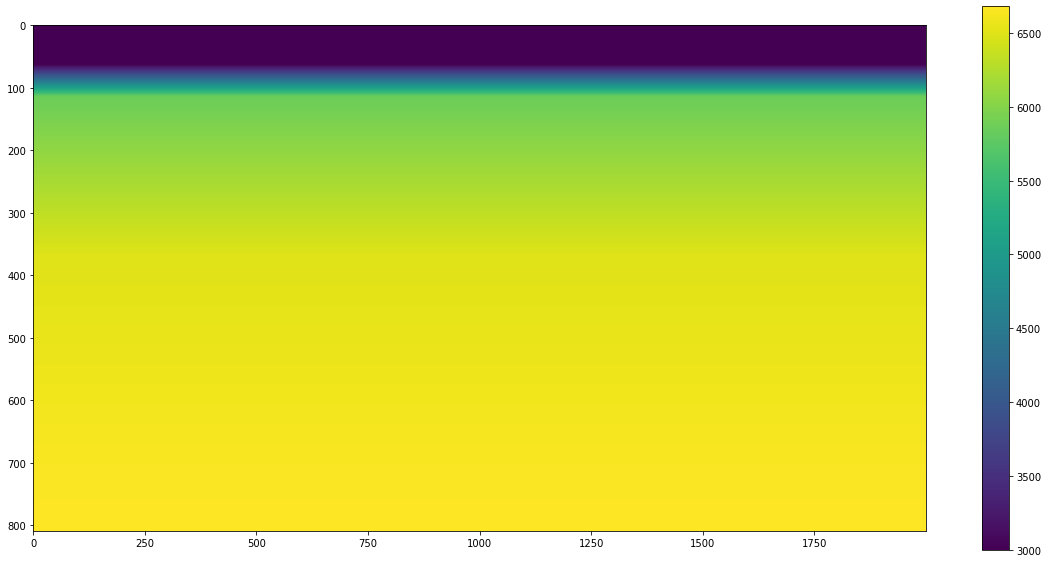

In [178]:
plt.figure(figsize=(20, 10))
plt.imshow(po,aspect=1.4)
plt.colorbar()

In [179]:
NX = np.shape(po)[1]
NY = np.shape(po)[0]

ny = NY
nx = NX

In [180]:
# Set parameters
num_dims = 2
#num_shots = 32
num_sources_per_shot = 1
#num_receivers_per_shot = 200

In [181]:
xrec = np.loadtxt('/disk/student/adhara/Spring2022/nature/BALANCED2/xrec.txt')
yrec = np.loadtxt('/disk/student/adhara/Spring2022/nature/BALANCED2/yrec.txt')

In [182]:
num_shots = 1
num_receivers_per_shot = len(yrec)
#yrec

In [185]:
# Create arrays containing the source and receiver locations
# x_s: Source locations [num_shots, num_sources_per_shot, num_dimensions]
# x_r: Receiver locations [num_shots, num_receivers_per_shot, num_dimensions]
x_s = torch.zeros(num_shots, num_sources_per_shot, num_dims)
x_s[:, 0, 1] = 85000
x_s[:, 0, 0] = 100 + 48 #RB Set source depth

x_r = torch.zeros(num_shots, num_receivers_per_shot, num_dims)
x_r[0, :, 1] = torch.Tensor(xrec)
x_r[0, :, 0] = torch.Tensor(yrec) 
x_r[:, :, 1] = x_r[0, :, 1].repeat(num_shots, 1)

#RB Shuffle shot coordinates
###idx = torch.randperm(num_shots)
###x_s = x_s.view(-1,2)[idx].view(x_s.size())

#RB Set Receiver depth
#x_r[0, :, 0] = 100.
#x_r[:, :, 0] = x_r[0, :, 0].repeat(num_shots, 1)

# Create true source amplitudes [nt, num_shots, num_sources_per_shot]
# I use Deepwave's Ricker wavelet function. The result is a normal Tensor - you
# can use whatever Tensor you want as the source amplitude.
source_amplitudes_true = (deepwave.wavelets.ricker(freq, nt, dt, 1/freq)
                          .reshape(-1, 1, 1)
                          .repeat(1, num_shots, num_sources_per_shot))

In [186]:
po = torch.Tensor(po)
prop = deepwave.scalar.Propagator({'vp': po.to(device)}, dx, pml_width=20)
receiver_amplitudes_all = prop(source_amplitudes_true.to(device),
                                x_s.to(device),
                                x_r.to(device), dt).cpu()

In [187]:
np.shape(receiver_amplitudes_all)

torch.Size([7500, 1, 831])

In [188]:
seis = np.squeeze(receiver_amplitudes_all)

np.shape(seis)

torch.Size([7500, 831])

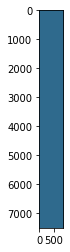

In [189]:
plt.imshow(seis)

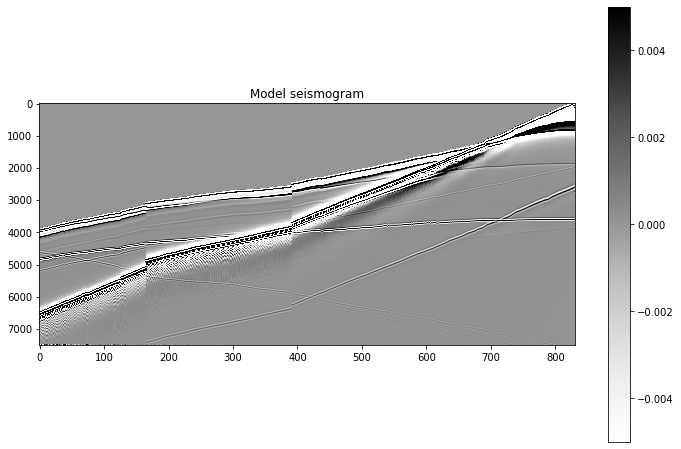

In [190]:
plot = True
if plot==True:
    plt.figure(figsize=(12, 8))
    plt.imshow(seis,vmin=-0.005, vmax=0.005, aspect=0.05,cmap='Greys')
    plt.colorbar()
    
    plt.title('Model seismogram')

In [153]:
wav = deepwave.wavelets.ricker(freq, nt, dt, 1/freq)

In [154]:
np.shape(wav)

torch.Size([7500])

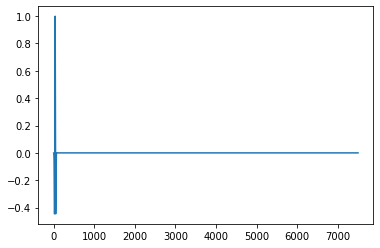

In [155]:
plt.plot(wav)

In [105]:
#madwav = np.loadtxt('/disk/student/adhara/Spring2022/nature/HRProject/statistical_wav.txt',skiprows=38)

In [106]:
#np.shape(madwav)

In [107]:
#plt.plot(madwav)

In [108]:
#wav1 = torch.Tensor(madwav)

In [109]:
#source_amplitudes_true1 = (wav1
#                          .reshape(-1, 1, 1)
#                          .repeat(1, num_shots, num_sources_per_shot))

In [110]:
#prop = deepwave.scalar.Propagator({'vp': po.to(device)}, dx, pml_width=20)
#receiver_amplitudes_all1 = prop(source_amplitudes_true1.to(device),
#                                x_s.to(device),
#                                x_r.to(device), dt).cpu()

In [111]:
#plot = True
#if plot==True:
#    plt.figure(figsize=(12, 8))
#    plt.imshow(receiver_amplitudes_all1[:,0,:],vmin=-0.03,vmax=0.03,aspect=0.05,cmap='Greys')
#    plt.colorbar()
    
#    plt.title('Model seismogram')

In [191]:
shot1d = scipy.io.loadmat('/disk/student/adhara/Spring2022/nature/BALANCED2/shot1_4.mat')

In [192]:
Shot1 = shot1d['Shot1']
Shot1[np.abs(Shot1)>150.0] = 100
np.shape(Shot1)

(5714, 831)

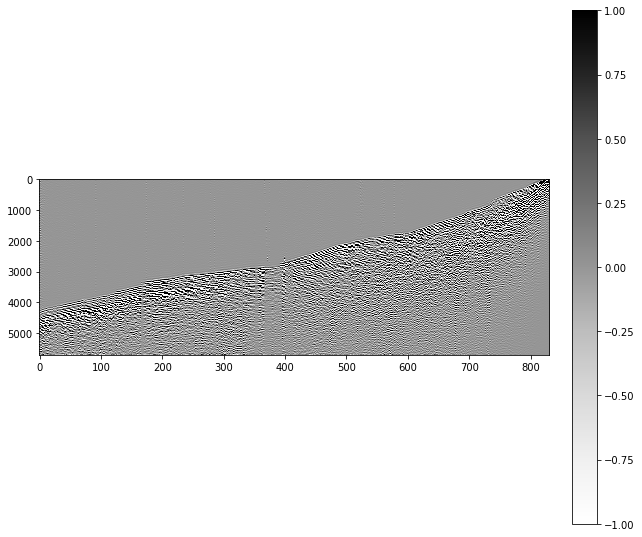

In [193]:
plt.figure(figsize=(10,30))
im = plt.imshow(Shot1,vmin=-1,vmax=1,aspect=0.05,cmap='Greys')
plt.colorbar(im,fraction=0.046, pad=0.04)

In [196]:
np.max(Shot1)

149.4130859375

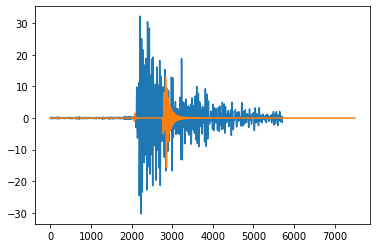

In [197]:
plt.plot(Shot1[:,500])
plt.plot(seis[:,500])

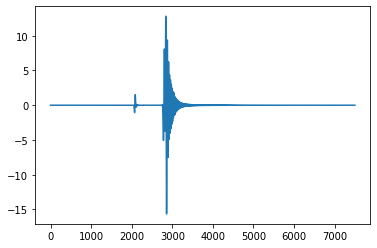

In [198]:
plt.plot(seis[:,500])

In [199]:
GPU = 3
# Specify which GPU to use (in multi GPU machines)
torch.cuda.set_device(GPU)  #RB Necessary if device <> 0
GPU_string='cuda:'+str(GPU)
devicek = torch.device(GPU_string)

In [200]:
Shot1 = torch.Tensor(Shot1)
Shot1 = Shot1.to(devicek)
Shot1_max, _ = torch.abs(Shot1).max(dim=0, keepdim=True)
Shot1_norm =  Shot1/(Shot1_max.abs()+1e-10)

In [201]:
net1out1 = po
net1out1 = net1out1.to(devicek)
net1out1.requires_grad = True
optimizer2 = torch.optim.Adam([{'params': [net1out1], 'lr':10}])
optimizer2.zero_grad()
prop = deepwave.scalar.Propagator({'vp': net1out1}, dx, pml_width=20)
Shot_sim = prop(source_amplitudes_true.to(devicek),
                x_s.to(devicek),
                x_r.to(devicek), dt)


RuntimeError: CUDA out of memory. Tried to allocate 146.31 GiB (GPU 3; 22.20 GiB total capacity; 82.56 MiB already allocated; 19.85 GiB free; 118.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [122]:
criterion1 = torch.nn.L1Loss()